# ex036
bug fix masked_img   
5-fold  
img size 512
output shape is half of input shape  
not channel shuffle  
bcewithlogits weight 0.3
  
effnet -> convnext
lr, epoch change

In [1]:
import gc
import os
import random
import time
import math

import cv2
import numpy as np
import matplotlib.pyplot as plt

# model
import torch
import torchvision
import torch.nn as nn
import timm
from torchvision.models.feature_extraction import create_feature_extractor
import torchvision.transforms.functional as TF

# data loader
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import DataLoader, Dataset

# training
from torch.optim import SGD, Adam, AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR, CosineAnnealingWarmRestarts, ReduceLROnPlateau, ExponentialLR, CyclicLR

# metric
from sklearn.metrics import fbeta_score, roc_auc_score

import wandb

import warnings
warnings.filterwarnings('ignore')

# config

In [2]:
BASE_DIR = "/working/"
INPUT_DIR = os.path.join(BASE_DIR, "input", "vesuvius-challenge-ink-detection")
TRAIN_DIR = os.path.join(INPUT_DIR, "train")
TEST_DIR = os.path.join(INPUT_DIR, "test")
# IMG_SIZE = [256, 256]
# IMG_SIZE = [128, 128]
IMG_SIZE = [512, 512]
SURFACE_LIST = [
                list(range(26, 36, 3)),
                list(range(27, 37, 3)),                
                list(range(25, 35, 3)),
                ]
print(len(SURFACE_LIST[0]))
print(SURFACE_LIST)

SURFACE_NUM = len(SURFACE_LIST[0])
# print("Start surface idx =",START_SURFACE)

# SLIDE_POS_LIST = [[idx*(IMG_SIZE[0]//6), idx*(IMG_SIZE[1]//6)] for idx in range(0, 3)]
SLIDE_POS_LIST = [[0,0], [IMG_SIZE[0]//2, 0], [0, IMG_SIZE[1]//2], [IMG_SIZE[0]//2, IMG_SIZE[1]//2]]
print("SLIDE_POS_LIST =", SLIDE_POS_LIST)
CFG = {
    "DEBUG" : False,
    # exp setting
    "EXP_CATEGORY" : "5fold",
    "EXP_NAME" : "exp037",
    "folds" : [0, 1, 2, 3, 4],

    # model
    # "model_name" : "tf_efficientnet_b2",
    "model_name" : "tf_efficientnet_b6",
    # "model_name" : "convnext_tiny",
    "inp_channels" : SURFACE_NUM,
    "out_channels" : 1,
    "pretrained" : True,
    # "out_indices" : [0,1,2,3,4],
    "out_indices": [0,1,2,3],
 
    # data   
    "img_size": IMG_SIZE,
    # "batch_size": 32,
    # "batch_size": 16,#batch normの関係か？16の方が64より安定してそう？？
    "batch_size": 8,
    "INPUT_DIR": INPUT_DIR,
    "TRAIN_DIR": TRAIN_DIR,
    "TEST_DIR": TEST_DIR,
    "surface_num": SURFACE_NUM,
    "surface_list": list(SURFACE_LIST),
    "slide_pos_list": SLIDE_POS_LIST,
    "RANDOM_SLIDE": True,
#     "surface_start_idx": START_SURFACE,
    # "TRAIN_DIR_LIST": [["1", "2"], ["1", "3"], ["2", "3"]],
    "TRAIN_DIR_LIST": [["1", "2_0", "2_1", "2_2"], 
                       ["1", "2_0", "2_1", "3"],
                       ["1", "2_0",  "2_2", "3"],
                       ["1", "2_1", "2_2", "3"],
                       ["2_0", "2_1", "2_2", "3"],
                       ],
#     "TRAIN_IDX_LIST" : ["1"],
    # "VALID_DIR_LIST": [["3"],["2"],["1"]],
    "VALID_DIR_LIST": [["3"], ["2_2"], ["2_1"], ["2_0"],["1"]],
    "TEST_DIR_LIST": ["a", "b"],

    # learning
    "n_epoch" : 15,
    "lr" : 1e-4,
    "T_max" : 5,
    "min_lr" : 1e-8,
    "weight_decay" : 1e-6,
    
    # cycliclr
    "step_size_up" : 5,
    "step_size_down" : 10,
    "max_lr" : 5e-4,
    "base_lr" : 5e-6,

    # etc
    "print_freq" : 1000,
    "random_seed" : 21,
    "num_workers": 2,
}


if CFG["model_name"]=="tf_efficientnet_b0":
    CFG["channel_nums"] = [320, 112, 40, 24, 16]
elif CFG["model_name"]=="tf_efficientnet_b2":
    CFG["channel_nums"] = [352, 120, 48, 24, 16]
elif CFG["model_name"]=="tf_efficientnet_b4":
    CFG["channel_nums"] = [448, 160, 56, 32, 24]
elif CFG["model_name"]=="tf_efficientnet_b6":
    # CFG["channel_nums"] = [576, 200, 72, 40, 32]
    CFG["channel_nums"] = [200, 72, 40, 32]
elif CFG["model_name"] == "convnext_tiny":
    CFG["channel_nums"] = [768, 384, 192, 96]


if CFG["DEBUG"]:
    CFG["n_epoch"] = 1
    CFG["EXP_NAME"] = "DEBUG"
    

CFG["OUTPUT_DIR"] = os.path.join(BASE_DIR, "output", CFG["EXP_NAME"])

4
[[26, 29, 32, 35], [27, 30, 33, 36], [25, 28, 31, 34]]
SLIDE_POS_LIST = [[0, 0], [256, 0], [0, 256], [256, 256]]


In [3]:
if not CFG["DEBUG"]:
    os.makedirs(CFG["OUTPUT_DIR"])
    os.makedirs(os.path.join(CFG["OUTPUT_DIR"], "imgs"))

In [4]:
if not CFG["DEBUG"]:
    WANDB_CONFIG = {'competition': 'vcid', '_wandb_kernel': 'taro'}
    os.environ["WANDB_SILENT"] = "true"
    wandb.init(project=WANDB_CONFIG["competition"], config=CFG, group=CFG["EXP_CATEGORY"], name=CFG["EXP_NAME"], reinit=True)

2023-04-24 08:06:55.456993: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-24 08:06:55.528527: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-24 08:06:56.091737: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib/python3.7/site-packages/cv2/../../lib64:/usr/local/cuda/lib64:/usr/local/cuda/lib:/

In [5]:
def logging_metrics_epoch(CFG, fold, epoch, slice_idx,train_loss_avg, valid_loss_avg, score, threshold, auc_score):
    wandb.log({f"train/fold{fold}": train_loss_avg,
                f"valid/fold{fold}": valid_loss_avg,
                f"score/fold{fold}":score,
                f"score threshold/fold{fold}":threshold,
                f"auc/fold{fold}":auc_score,
                f"epoch/fold{fold}":epoch+slice_idx*CFG["n_epoch"],
                })


In [6]:
def seed_everything(seed=CFG["random_seed"]):
    #os.environ['PYTHONSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic =True
    torch.backends.cudnn.benchmark = False
seed_everything()

# device optimization
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(f'Using device: {device}')

Using device: cuda


In [7]:
def asMinutes(s):
    """Convert Seconds to Minutes."""
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    """Accessing and Converting Time Data."""
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))

class AverageMeter(object):
    """Computes and stores the average and current value."""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

# metric

In [8]:
def fbeta_numpy(targets, preds, beta=0.5, smooth=1e-5):
    y_true_count = targets.sum()
    ctp = preds[targets==1].sum()
    cfp = preds[targets==0].sum()
    beta_squared = beta * beta

    c_precision = ctp / (ctp + cfp + smooth)
    c_recall = ctp / (y_true_count + smooth)
    dice = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall + smooth)

    return dice

def calc_fbeta_auc(mask, mask_pred):
    mask = mask.astype(int).flatten()
    mask_pred = mask_pred.flatten()

    best_th = 0
    best_dice = 0
    dice_list = [] 
    # for th in np.array(range(10, 50+1, 5)) / 100:
    for th in np.array(range(10, 100+1, 5)) / 100:
        # dice = fbeta_score(mask, (mask_pred >= th).astype(int), beta=0.5)
        dice = fbeta_numpy(mask, (mask_pred >= th).astype(int), beta=0.5)
        dice_list.append(dice)
        # print(f'\t th: {th}, fbeta: {dice}')
        if dice > best_dice:
            best_dice = dice
            best_th = th
    
    auc = roc_auc_score(mask, mask_pred)
    # Logger.info(f'best_th: {best_th}, fbeta: {best_dice}')
    return best_dice, best_th, auc, dice_list


def calc_cv(mask_gt, mask_pred):
    best_dice, best_th, auc, dice_list = calc_fbeta_auc(mask_gt, mask_pred)

    return best_dice, best_th, auc, dice_list

# model

In [9]:
# class Encoder(nn.Module):
#     def __init__(self, CFG):
#         super().__init__()
#         self.encoder = timm.create_model(CFG["model_name"], in_chans=CFG["inp_channels"], features_only=True, out_indices=CFG["out_indices"], pretrained=CFG["pretrained"])
#     def forward(self, img):
#         skip_connection_list = self.encoder(img)
#         return skip_connection_list

# class UpConv(nn.Module):
#     def __init__(self, in_channels, out_channels):
#         super().__init__()
#         self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
#         self.bn1 = nn.BatchNorm2d(in_channels)
#         self.conv = nn.Conv2d(in_channels, out_channels, kernel_size = 2, padding="same")
#         self.bn2 = nn.BatchNorm2d(out_channels)

#     def forward(self, x):
#         x = self.up(x)
#         x = self.bn1(x)
#         x = self.conv(x)
#         x = self.bn2(x)
#         return x


# class Decoder(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.UpConv_0 = UpConv(CFG["channel_nums"][0], CFG["channel_nums"][1])
#         self.UpConv_1 = UpConv(CFG["channel_nums"][1]*2, CFG["channel_nums"][2])
#         self.UpConv_2 = UpConv(CFG["channel_nums"][2]*2, CFG["channel_nums"][3])
#         self.UpConv_3 = UpConv(CFG["channel_nums"][3]*2, CFG["channel_nums"][4])
#         # self.UpConv_4 = UpConv(CFG["channel_nums"][4]*2, CFG["channel_nums"][4])
    
#     def forward(self, skip_connection_list):
#         emb = self.UpConv_0(skip_connection_list[4]) # emb.shape = (None, 160, 14, 14)
#         emb_cat = torch.cat([skip_connection_list[3], emb], dim = 1)
        
#         emb = self.UpConv_1(emb_cat)
#         emb_cat = torch.cat([skip_connection_list[2], emb], dim = 1)
        
#         emb = self.UpConv_2(emb_cat)
#         emb_cat = torch.cat([skip_connection_list[1], emb], dim = 1)
        
#         emb = self.UpConv_3(emb_cat)
#         emb_cat = torch.cat([skip_connection_list[0], emb], dim = 1)

#         # emb_cat = self.UpConv_4(emb_cat)
        
#         return emb_cat

# class SegModel(nn.Module):
#     def __init__(self, CFG):
#         super().__init__()
#         self.encoder = Encoder(CFG)
#         self.decoder = Decoder()
#         self.head = nn.Sequential(
#             nn.Conv2d(CFG["channel_nums"][-1]*2, CFG["out_channels"], kernel_size=1, stride=1, padding=0),
#             # nn.Sigmoid()
#         )
#     def forward(self, img):
#         skip_connection_list = self.encoder(img)
#         emb = self.decoder(skip_connection_list)
#         output = self.head(emb)
#         assert output is not None, f"output is None, {img}, {skip_connection_list}, {emb}, {output}"
#         return output

In [10]:
class Encoder(nn.Module):
    def __init__(self, CFG):
        super().__init__()
        self.encoder = timm.create_model(CFG["model_name"], in_chans=CFG["inp_channels"], 
                                         features_only=True, out_indices=CFG["out_indices"], pretrained=CFG["pretrained"])
    def forward(self, img):
        skip_connection_list = self.encoder(img)
        return skip_connection_list

class UpConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size = 2, padding="same")
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = self.up(x)
        x = self.bn1(x)
        x = self.conv(x)
        x = self.bn2(x)
        return x

"""
下に２層を使わない
"""
# class Decoder(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.UpConv_0 = UpConv(CFG["channel_nums"][0], CFG["channel_nums"][1])
#         self.UpConv_1 = UpConv(CFG["channel_nums"][1]*2, CFG["channel_nums"][2])
#         self.UpConv_2 = UpConv(CFG["channel_nums"][2]*2, CFG["channel_nums"][2])
    
#     def forward(self, skip_connection_list):
#         emb = self.UpConv_0(skip_connection_list[2]) # emb.shape = (None, 160, 14, 14)
#         emb_cat = torch.cat([skip_connection_list[1], emb], dim = 1)
        
#         emb = self.UpConv_1(emb_cat)
#         emb_cat = torch.cat([skip_connection_list[0], emb], dim = 1)
        
#         return emb_cat

"""
下に1層を使わない
"""
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.UpConv_0 = UpConv(CFG["channel_nums"][0], CFG["channel_nums"][1])
        self.UpConv_1 = UpConv(CFG["channel_nums"][1]*2, CFG["channel_nums"][2])
        self.UpConv_2 = UpConv(CFG["channel_nums"][2]*2, CFG["channel_nums"][3])
        self.UpConv_3 = UpConv(CFG["channel_nums"][3]*2, CFG["channel_nums"][3])
    
    def forward(self, skip_connection_list):
        emb = self.UpConv_0(skip_connection_list[3]) # emb.shape = (None, 160, 14, 14)
        emb_cat = torch.cat([skip_connection_list[2], emb], dim = 1)
        
        emb = self.UpConv_1(emb_cat)
        emb_cat = torch.cat([skip_connection_list[1], emb], dim = 1)
        
        emb = self.UpConv_2(emb_cat)
        emb_cat = torch.cat([skip_connection_list[0], emb], dim = 1)
        
        return emb_cat
    
# class Decoder(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.UpConv_0 = UpConv(CFG["channel_nums"][0], CFG["channel_nums"][1])
#         self.UpConv_1 = UpConv(CFG["channel_nums"][1]*2, CFG["channel_nums"][2])
#         self.UpConv_2 = UpConv(CFG["channel_nums"][2]*2, CFG["channel_nums"][3])
#         self.UpConv_3 = UpConv(CFG["channel_nums"][3]*2, CFG["channel_nums"][4])
#         self.UpConv_4 = UpConv(CFG["channel_nums"][4]*2, CFG["channel_nums"][4])
    
#     def forward(self, skip_connection_list):
#         emb = self.UpConv_0(skip_connection_list[4]) # emb.shape = (None, 160, 14, 14)
#         emb_cat = torch.cat([skip_connection_list[3], emb], dim = 1)
        
#         emb = self.UpConv_1(emb_cat)
#         emb_cat = torch.cat([skip_connection_list[2], emb], dim = 1)
        
#         emb = self.UpConv_2(emb_cat)
#         emb_cat = torch.cat([skip_connection_list[1], emb], dim = 1)
        
#         emb = self.UpConv_3(emb_cat)
#         emb_cat = torch.cat([skip_connection_list[0], emb], dim = 1)

#         emb_cat = self.UpConv_4(emb_cat)
        
#         return emb_cat

class SegModel(nn.Module):
    def __init__(self, CFG):
        super().__init__()
        self.encoder = Encoder(CFG)
        self.decoder = Decoder()
        self.head = nn.Sequential(
            nn.Conv2d(CFG["channel_nums"][-1]*2, CFG["out_channels"], kernel_size=1, stride=1, padding=0),
            # nn.Sigmoid()
        )
    def forward(self, img):
        skip_connection_list = self.encoder(img)
        emb = self.decoder(skip_connection_list)
        output = self.head(emb)
#         output = TF.resize(img=output, size=(CFG["img_size"][0], CFG["img_size"][1]))
        return output

# Dataset

In [11]:
train_transforms = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.RandomCrop(int(CFG["img_size"][0]*0.8), int(CFG["img_size"][1]*0.8), p=0.3),
    A.Blur(blur_limit=3, p=0.3),
    A.Resize(CFG["img_size"][0], CFG["img_size"][1]),
    ToTensorV2(),
])

valid_transforms = A.Compose([
    ToTensorV2(),
])

In [12]:
class VCID_Dataset(Dataset):
    def __init__(self, CFG, data_dir_list, surface_list, surface_volumes=None, slide_pos=[0,0], mode="train", transform=None):
        # get config
        self.mode = mode
        self.RANDOM_SLIDE = CFG["RANDOM_SLIDE"]
        self.img_size = CFG["img_size"]
        if self.mode=="train":  self.DATADIR = CFG["TRAIN_DIR"]
        elif self.mode=="valid":    self.DATADIR = CFG["TRAIN_DIR"]
        elif self.mode == "test":   self.DATADIR = CFG["TEST_DIR"]
        self.data_dir_list = data_dir_list
        self.surface_list = surface_list
        self.slide_pos = slide_pos
        self.transform = transform
        
        # get imgs
        # print("initializing dataset...")
        self.imgs = []
        for data_dir in self.data_dir_list:
            img_path = os.path.join(self.DATADIR, data_dir, "mask.png")
            # print(img_path)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = img.reshape(img.shape[0], img.shape[1], 1) # (h, w, channel=1)
            assert img is not None, "img is None. data path is wrong"
            self.imgs.append(img)  
        
        # get and split surface
        if surface_volumes is None:
            self.surface_vols = self.read_surfacevols()
        else:
            # print("using loaded surface_vols")
            self.surface_vols = surface_volumes
       
        # split grid
        self.get_all_grid()
        self.fileter_grid()
        self.get_flatten_grid()
        # print("split grid done.") 
       
        # get label imgs
        if self.mode == "train" or self.mode == "valid":
            self.labels = []
            for data_dir in self.data_dir_list:
                label_path = os.path.join(self.DATADIR, data_dir, "inklabels.png")
                assert os.path.exists(label_path), f"{label_path} is not exist."
                # read label
                label = cv2.imread(label_path, cv2.IMREAD_GRAYSCALE)
                label = label.reshape(label.shape[0], label.shape[1], 1) # (h, w, channel=1)
                self.labels.append(label)# 画像サイズがそれぞれ違うので単純にconcatできずlist化しているs
        # print("initializing dataset done.")

    def get_surface_volumes(self):
        return self.surface_vols

    def read_surfacevols(self):
        """ read surface volume by data_dir_list and surface_list 
            Returns:surface_vuls (list): surface volume list [array(h,w,channel=surface_num), array(), ...]
        """
        surface_vols = []
        # print("reading surface volume...")
        for data_dir in self.data_dir_list:
            surface_vol_ = None
            for read_idx, surface_idx in enumerate(self.surface_list):
                # print("\r", f"reading idx : {read_idx+1}/{len(self.surface_list)}", end="")
                surface_path = os.path.join(self.DATADIR, data_dir, "surface_volume", f"{surface_idx:02}.tif")
                surface_vol = cv2.imread(surface_path, cv2.IMREAD_GRAYSCALE)
                surface_vol = surface_vol.reshape(surface_vol.shape[0], surface_vol.shape[1], 1) # (h, w, channel=1)
                if surface_vol_ is None:
                    surface_vol_ = surface_vol
                else:
                    surface_vol_ = np.concatenate([surface_vol_, surface_vol], axis=2) # (h, w, channel=surface_num)
            surface_vols.append(surface_vol_)
            # print(f"  => read surface volume done. [{data_dir}]")
        return surface_vols


    def get_grid_img(self, img, grid_idx):
        """ crop grid img from original img"""
        img_grid = img[(grid_idx[0]*self.img_size[0]) + self.slide_pos[0] : ((grid_idx[0]+1)*self.img_size[0]) + self.slide_pos[0],
                        (grid_idx[1]*self.img_size[1]) + self.slide_pos[1] : ((grid_idx[1]+1)*self.img_size[1]) + self.slide_pos[1]]
        return img_grid
    
    def get_grid_img_and_mask(self, img, mask, grid_idx):
        """ crop grid img from original img"""
        if self.RANDOM_SLIDE and self.mode=="train" and random.random() < 0.5:
            if (grid_idx[0]!=0 and grid_idx[1]!=0) and (grid_idx[0]!=img.shape[0]//self.img_size[0] and grid_idx[1]!=img.shape[1]//self.img_size[1]):
                rand_pos = [np.random.randint(0, self.img_size[0]//4) - self.img_size[0]//4, np.random.randint(0, self.img_size[1]//4)-self.img_size[1]//4]
            else:
                rand_pos = [0, 0]
        else:
            rand_pos = [0, 0]
        self.rand_pos = rand_pos
        img_grid = img[(grid_idx[0]*self.img_size[0]) + self.slide_pos[0] + rand_pos[0] : ((grid_idx[0]+1)*self.img_size[0]) + self.slide_pos[0] + rand_pos[0],
                        (grid_idx[1]*self.img_size[1]) + self.slide_pos[1] + rand_pos[1] : ((grid_idx[1]+1)*self.img_size[1]) + self.slide_pos[1] + rand_pos[1]]
        mask_grid = mask[(grid_idx[0]*self.img_size[0]) + self.slide_pos[0] + rand_pos[0] : ((grid_idx[0]+1)*self.img_size[0]) + self.slide_pos[0] + rand_pos[0],
                         (grid_idx[1]*self.img_size[1]) + self.slide_pos[1] + rand_pos[1] : ((grid_idx[1]+1)*self.img_size[1]) + self.slide_pos[1] + rand_pos[1]]
        return img_grid/255., mask_grid/255.
    
    def get_masked_img(self, img, mask):
        """ multiply mask to surface_volumes """
        masked_img = None
        for channel in range(img.shape[2]):
            img_channel = img[:,:,channel].reshape(img.shape[0], img.shape[1],1)
            masked = img_channel*mask
            if masked_img is None:
                masked_img = masked.reshape(masked.shape[0], masked.shape[1], 1)
            else:
                masked = masked.reshape(masked.shape[0], masked.shape[1], 1)
                masked_img = np.concatenate([masked_img, masked], axis=2)
        return masked_img
    
    
    def get_all_grid(self):
        """ get all grid indices by img size and grid size
        """
        self.grid_indices = []
        for img in self.imgs:
            self.x_grid_size = (img.shape[0] - self.slide_pos[0]) // self.img_size[0]
            self.y_grid_size = (img.shape[1] - self.slide_pos[1]) // self.img_size[1]
            grid_img = []
            for i in range(self.x_grid_size):
                for j in range(self.y_grid_size):
                    grid_img.append([i, j])
            self.grid_indices.append(grid_img)
        return self.grid_indices
          
    def fileter_grid(self):
        """ get grid indices which mask is not 0 by all grid indices"""
        grid_indices_all = []
        for img, grid_indices in zip(self.imgs, self.grid_indices):
            grid_indices_copy = grid_indices.copy()
            for grid_idx in grid_indices:
                img_grid = self.get_grid_img(img, grid_idx)
                if img_grid.sum() == 0:
                    grid_indices_copy.remove(grid_idx)
            grid_indices_all.append(grid_indices_copy)
        self.grid_indices = grid_indices_all
        return self.grid_indices

    def get_flatten_grid(self):
        """ get flatten index list by grid indices
            Returns:flatten_grid (list): flatten index list [[img_idx, grid_idx], [img_idx, grid_idx], ...]
        """
        flatten_grid = []
        for img_idx, grid_indices in enumerate(self.grid_indices):
            for grid_idx in grid_indices:
                grid_imgidx_list = [img_idx]
                grid_imgidx_list.extend(grid_idx)
                flatten_grid.append(grid_imgidx_list)
        self.flatten_grid = flatten_grid
        return self.flatten_grid
    
    def channel_shuffle(self, img):
        img = img.transpose(2, 0, 1)
        np.random.shuffle(img)
        return img.transpose(1, 2, 0)

    def __len__(self):
        return len(self.flatten_grid)

    def __getitem__(self, idx):
        # get indices
        img_grid_idx = self.flatten_grid[idx]
        img_idx = img_grid_idx[0]
        grid_idx = img_grid_idx[1:]
        # get img & surface_vol
        mask = self.imgs[img_idx]
        surface_vol = self.surface_vols[img_idx]
        # mask = self.get_grid_img(mask, grid_idx)/255.
        # surface_vol = self.get_grid_img(surface_vol, grid_idx)/255.
        mask, surface_vol = self.get_grid_img_and_mask(mask, surface_vol, grid_idx)
        # multiple small mask 
        assert surface_vol.shape[0]==mask.shape[0] and surface_vol.shape[1]==mask.shape[1] , "surface_vol_list shape is not same as img shape"
        img = surface_vol
        # transform
        if self.mode == "test":
            if self.transform:
                img = self.transform(image=img)["image"]
            else:
                img = img.transpose(2, 0, 1)
                img = torch.tensor(img, dtype=torch.float32)
            return img, grid_idx
        elif self.mode == "train" or self.mode=="valid":
            # get label(segmentation mask)
            label = self.labels[img_idx]
            label = self.get_grid_img(label, grid_idx)
            # if self.mode == "train":
            #     img = self.channel_shuffle(img)
            if self.transform:
                transformed = self.transform(image=img, mask=label)
                img = transformed["image"]
                label = transformed["mask"]
                label = label.permute(2, 0, 1)/255. # (channel, h, w)
                # label = TF.resize(img=label, size=(self.img_size[0]//2, self.img_size[1]//2))
            else:
                img = img.transpose(2, 0, 1) # (channel, h, w)
                label = label.transpose(2, 0, 1)/255. # (channel, h, w){}
                img = torch.tensor(img, dtype=torch.float32)
                label = torch.tensor(label, dtype=torch.float32)
                # label = TF.resize(img=label, size=(self.img_size[0]//2, self.img_size[1]//2))
            assert img is not None and label is not None, f"img or label is None {img} {label}, {img_idx}, {grid_idx}, {self.rand_pos}"
            return img, label, grid_idx


In [13]:
# valid_dirs = CFG["VALID_DIR_LIST"][0]
# surface_list = SURFACE_LIST[0]
# print("dataset")
# dataset_notrans = VCID_Dataset(CFG, valid_dirs, surface_list, mode="train")
# surface_volumes = dataset_notrans.surface_vols
# print("dataloader")
# dataloader_notrans = DataLoader(dataset_notrans, 4, shuffle=False, num_workers=0)

# imshow_batch = 10

# for batch_idx, (imgs, labels, grid_idx) in enumerate(dataloader_notrans):
#     img = imgs[0].permute(1, 2, 0)
#     if batch_idx < 2:
#         plt.figure(figsize=(20,5))
#         for channel in range(img.shape[2]):
#             plt.subplot(1, img.shape[2], channel+1)
#             plt.imshow(img[:,:,channel], cmap="gray")
#         plt.show()
#         [print(np.max(img[:,:,idx].numpy())) for idx in range(img.shape[2])]
        
#     if batch_idx >= imshow_batch:
#         break    

# img_hist, img_bins = np.histogram(np.array(img[:,:,0]).flatten())
# plt.figure()
# plt.plot(img_hist)
# plt.show()
# print(img[:,:,0])


In [14]:
# valid_dirs = CFG["VALID_DIR_LIST"][0]
# surface_list = SURFACE_LIST[0]
# print("dataset")
# dataset_notrans = VCID_Dataset(CFG, valid_dirs, surface_list, mode="train")
# surface_volumes = dataset_notrans.surface_vols
# print("dataloader")
# dataloader_notrans = DataLoader(dataset_notrans, 4, shuffle=False, num_workers=0)

# imshow_batch = 10

# for batch_idx, (imgs, labels, grid_idx) in enumerate(dataloader_notrans):
#     img = imgs[0].permute(1, 2, 0)
#     if batch_idx < 2:
#         plt.figure(figsize=(20,5))
#         for channel in range(img.shape[2]):
#             plt.subplot(1, img.shape[2], channel+1)
#             plt.imshow(img[:,:,channel], cmap="gray")
#         plt.show()
#         [print(np.max(img[:,:,idx].numpy())) for idx in range(img.shape[2])]
#     if batch_idx >= imshow_batch:
#         break    

# img_hist, img_bins = np.histogram(np.array(img[:,:,0]).flatten())
# plt.figure()
# plt.plot(img_hist)
# plt.show()
# print(img[:,:,0])


In [15]:
# print("dataset")
# dataset_notrans = VCID_Dataset(CFG, valid_dirs, surface_list, surface_volumes, slide_pos=[0,50],mode="train")
# print("dataloader")
# dataloader_notrans = DataLoader(dataset_notrans, 4, shuffle=False, num_workers=0)

# imshow_batch = 10

# for batch_idx, (imgs, labels, grid_idx) in enumerate(dataloader_notrans):
#     img = imgs[0].permute(1, 2, 0)
#     if batch_idx == 1:
#         plt.figure(figsize=(20,5))
#         for channel in range(img.shape[2]):
#             plt.subplot(1, img.shape[2], channel+1)
#             plt.imshow(img[:,:,channel], cmap="gray")
#         plt.show()
#         [print(np.max(img[:,:,idx].numpy())) for idx in range(img.shape[2])]
#     if batch_idx >= imshow_batch:
#         break    

# img_hist, img_bins = np.histogram(np.array(img[:,:,0]).flatten())
# plt.figure()
# plt.plot(img_hist)
# plt.show()
# print(img[:,:,0])


In [16]:
# valid_dirs = CFG["VALID_DIR_LIST"][0]
# surface_list = SURFACE_LIST[0]
# print("dataset")
# dataset_notrans = VCID_Dataset(CFG, valid_dirs, surface_list, mode="train", transform=train_transforms)
# print("dataloader")
# dataloader_notrans = DataLoader(dataset_notrans, 4, shuffle=False, num_workers=0)


# imshow_batch = 10

# for batch_idx, (imgs, labels, grid_idx) in enumerate(dataloader_notrans):
#     img = imgs[0].permute(1, 2, 0)
#     if batch_idx == 0:
#         plt.figure(figsize=(20,5))
#         for channel in range(img.shape[2]):
#             plt.subplot(1, img.shape[2], channel+1)
#             plt.imshow(img[:,:,channel], cmap="gray")
#         plt.show()
#         [print(np.max(img[:,:,idx].numpy())) for idx in range(img.shape[2])]
#     if batch_idx >= imshow_batch:
#         break    

# img_hist, img_bins = np.histogram(np.array(img[:,:,0]).flatten())
# plt.figure()
# plt.plot(img_hist)
# plt.show()
# print(img[:,:,0])

# Loss

In [17]:
#PyTorch
ALPHA = 0.1 # < 0.5 penalises FP more, > 0.5 penalises FN more
CE_RATIO = 0.90 #weighted contribution of modified CE loss compared to Dice loss

class ComboLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(ComboLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1, alpha=ALPHA, eps=1e-9):
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        #True Positives, False Positives & False Negatives
        intersection = (inputs * targets).sum()    
        dice = (2. * intersection + smooth) / (inputs.sum() + targets.sum() + smooth)
        
        inputs = torch.clamp(inputs, eps, 1.0 - eps)       
        out = - (ALPHA * ((targets * torch.log(inputs)) + ((1 - ALPHA) * (1.0 - targets) * torch.log(1.0 - inputs))))
        weighted_ce = out.mean(-1)
        # if dice is None or dice > 0:
        #     combo = weighted_ce
        # else:
        #     combo = (CE_RATIO * weighted_ce) - ((1 - CE_RATIO) * dice)
        combo = (CE_RATIO * weighted_ce) - ((1 - CE_RATIO) * dice)
        assert combo is not None, f"combo loss is None, weighted_ce: {weighted_ce}, dice: {dice}"
        return combo

# train valid fn

In [18]:
def train_fn(train_loader, model, criterion, epoch ,optimizer, scheduler):
    model.train()
    batch_time = AverageMeter()
    losses = AverageMeter()
    start = end = time.time()
    for batch_idx, (images, targets, _) in enumerate(train_loader):
        images = images.to(device, non_blocking = True).float()
        targets = targets.to(device, non_blocking = True).float()     
        preds = model(images)
        preds = TF.resize(img=preds, size=(CFG["img_size"][0], CFG["img_size"][1]))
        assert preds is not None, f"preds is None, {preds}, {images}, {targets}"
        loss = criterion(preds, targets)
        preds = torch.sigmoid(preds)
        assert loss is not None, f"loss is None, {loss}, {preds}, {targets}"
        losses.update(loss.item(), CFG["batch_size"]) 
        targets = targets.detach().cpu().numpy().ravel().tolist()
        preds = preds.detach().cpu().numpy().ravel().tolist()
        loss.backward() # パラメータの勾配を計算
        optimizer.step() # モデル更新
        optimizer.zero_grad() # 勾配の初期化
                
        batch_time.update(time.time() - end)
        end = time.time()
        if batch_idx % CFG["print_freq"] == 0 or batch_idx == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                    'Elapsed {remain:s} '
                    'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                    .format(
                        epoch, batch_idx, len(train_loader), batch_time=batch_time, loss=losses,
                        remain=timeSince(start, float(batch_idx+1)/len(train_loader)),
            ))
        del preds, images, targets
    gc.collect()
    torch.cuda.empty_cache()
    return losses.avg

In [19]:
def valid_fn(model, valid_loader, criterion=None):
    model.eval()# モデルを検証モードに設定
    test_targets = []
    test_preds = []
    test_grid_idx = []
    batch_time = AverageMeter()
    losses = AverageMeter()
    start = end = time.time()
    for batch_idx, (images, targets, grid_idx) in enumerate(valid_loader):
        images = images.to(device, non_blocking = True).float()
        targets = targets.to(device, non_blocking = True).float()
        with torch.no_grad():
            preds = model(images)
            preds = TF.resize(img=preds, size=(CFG["img_size"][0], CFG["img_size"][1]))
            assert preds is not None, f"preds is None, {preds}, {images}, {targets}"
            if not criterion is None:
                loss = criterion(preds, targets)
                assert loss is not None, f"loss is None, {loss}, {preds}, {targets}"
            preds = torch.sigmoid(preds)
        if not criterion is None:
            losses.update(loss.item(), CFG["batch_size"])
        batch_time.update(time.time() - end)

        targets = targets.detach().cpu().numpy()
        preds = preds.detach().cpu().numpy()
        
        test_preds.extend([preds[idx, :,:,:].transpose(1,2,0) for idx in range(preds.shape[0])])
        test_targets.extend([targets[idx, :,:,:].transpose(1,2,0) for idx in range(targets.shape[0])])
        test_grid_idx.extend([[x_idx, y_idx] for x_idx, y_idx in zip(grid_idx[0].tolist(), grid_idx[1].tolist())])

        if (batch_idx % CFG["print_freq"] == 0 or batch_idx == (len(valid_loader)-1)) and (not criterion is None):
            print('EVAL: [{0}/{1}] '
                'Elapsed {remain:s} '
                'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                .format(
                    batch_idx, len(valid_loader), batch_time=batch_time, loss=losses,
                    remain=timeSince(start, float(batch_idx+1)/len(valid_loader)),
                ))
        del preds, images, targets
        gc.collect()
        torch.cuda.empty_cache()
    if criterion is None:
        return test_targets, test_preds, test_grid_idx
    else:
        return test_targets, test_preds, test_grid_idx, losses.avg

# training loop

In [20]:
# def concat_grid_img(img_list, label_list, grid_idx_list, valid_dir_list):
#     # concat pred img and label to original size
#     img_path = os.path.join(CFG["TRAIN_DIR"], valid_dir_list[0], "mask.png")
#     img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
#     img = img.reshape(img.shape[0], img.shape[1], 1)
#     pred_img = np.zeros_like(img).astype(np.float32)
#     label_img = np.zeros_like(img).astype(np.float32)
#     for img_idx, grid_idx in enumerate(grid_idx_list):
#         pred_img[grid_idx[0]*CFG["img_size"][0]:(grid_idx[0]+1)*CFG["img_size"][0],
#                 grid_idx[1]*CFG["img_size"][1]:(grid_idx[1]+1)*CFG["img_size"][1], :] += img_list[img_idx]
        
#         label_img[grid_idx[0]*CFG["img_size"][0]:(grid_idx[0]+1)*CFG["img_size"][0],
#                 grid_idx[1]*CFG["img_size"][1]:(grid_idx[1]+1)*CFG["img_size"][1], :] += label_list[img_idx]
#     return pred_img, label_img

In [21]:
def concat_grid_img(img_list, label_list, grid_idx_list, valid_dir_list, slide_pos=[0,0]):
    # concat pred img and label to original size
    img_path = os.path.join(CFG["TRAIN_DIR"], valid_dir_list[0], "mask.png")
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = img.reshape(img.shape[0], img.shape[1], 1)
    pred_img = np.zeros_like(img).astype(np.float32)
    label_img = np.zeros_like(img).astype(np.float32)
    for img_idx, grid_idx in enumerate(grid_idx_list):
        pred_img[grid_idx[0]*CFG["img_size"][0]+slide_pos[0] : (grid_idx[0]+1)*CFG["img_size"][0]+slide_pos[0],
                grid_idx[1]*CFG["img_size"][1]+slide_pos[1] : (grid_idx[1]+1)*CFG["img_size"][1]+slide_pos[1], :] += img_list[img_idx]
        
        label_img[grid_idx[0]*CFG["img_size"][0]+slide_pos[0] : (grid_idx[0]+1)*CFG["img_size"][0]+slide_pos[0],
                grid_idx[1]*CFG["img_size"][1]+slide_pos[1] : (grid_idx[1]+1)*CFG["img_size"][1]+slide_pos[1], :] += label_list[img_idx]
    return pred_img, label_img

In [22]:
def save_and_plot_oof(mode, fold, slice_idx, valid_preds_img, valid_targets_img, valid_preds_binary):
    cv2.imwrite(os.path.join(CFG["OUTPUT_DIR"], "imgs", f"fold{fold}_{mode}_slice{slice_idx}_valid_pred_img.png"), valid_preds_img*255)
    cv2.imwrite(os.path.join(CFG["OUTPUT_DIR"], "imgs", f"fold{fold}_{mode}_slice{slice_idx}_valid_predbin_img.png"), valid_preds_binary*255)
    cv2.imwrite(os.path.join(CFG["OUTPUT_DIR"], "imgs", f"fold{fold}_{mode}_slice{slice_idx}_valid_targets_img.png"), valid_targets_img*255)
    
    # plot preds & binary preds
    # plt.figure(dpi=100)
    # plt.subplot(1,3,1)
    # plt.imshow(valid_preds_img)
    # plt.subplot(1,3,2)
    # plt.imshow(valid_preds_binary)
    # plt.subplot(1,3,3)
    # plt.imshow(valid_targets_img)
    # plt.show()
                

In [23]:
def training_loop(CFG):
    best_score_list = []
    best_threshold_list = []
    best_epoch_list = []
    slice_ave_score_list = []
    slice_ave_auc_list = []
    slice_ave_score_threshold_list = []
    for fold in CFG["folds"]:
        print(f"-- fold{fold} training start --")
 
        # set model & learning fn
        model = SegModel(CFG)
        model = model.to(device)
        valid_img_slice = []
        # criterion = nn.BCELoss()
        # criterion = ComboLoss()
        weights = torch.tensor([0.3]).cuda()
        criterion = torch.nn.BCEWithLogitsLoss(pos_weight=weights)
        optimizer = AdamW(model.parameters(), lr=CFG["lr"], weight_decay=CFG["weight_decay"], amsgrad=False)
        scheduler = CosineAnnealingLR(optimizer, T_max=CFG["T_max"], eta_min=CFG["min_lr"], last_epoch=-1)
        # scheduler = ExponentialLR(optimizer, gamma=0.60)
        scheduler = CyclicLR(optimizer, base_lr=CFG["base_lr"], max_lr=CFG["max_lr"],
                            step_size_up=CFG["step_size_up"], step_size_down=CFG["step_size_down"], 
                            cycle_momentum=False, mode='triangular2')
        
        # training
        best_score = -np.inf
        best_auc = -np.inf
        best_valloss = np.inf
        best_auc_valloss = np.inf
        best_threshold = -1
        start_time = time.time()
        best_epoch = -1
        best_auc_epoch = -1
        valid_slice_ave = None       
        for slice_idx, surface_list in enumerate(SURFACE_LIST):
            print("surface_list: ", surface_list)
            # separate train/valid data 
            train_dirs = CFG["TRAIN_DIR_LIST"][fold]
            valid_dirs = CFG["VALID_DIR_LIST"][fold]
            train_dataset = VCID_Dataset(CFG, train_dirs, surface_list, mode="train", transform=train_transforms)
            valid_dataset = VCID_Dataset(CFG, valid_dirs, surface_list, mode="valid", transform=valid_transforms)
            train_loader = DataLoader(train_dataset, batch_size=CFG["batch_size"], shuffle = True,
                                        num_workers = CFG["num_workers"], pin_memory = True)
            valid_loader = DataLoader(valid_dataset, batch_size=CFG["batch_size"], shuffle = False,
                                        num_workers = CFG["num_workers"], pin_memory = True)
            for epoch in range(1, CFG["n_epoch"] + 1):
                epochs_ = epoch + CFG["n_epoch"] * slice_idx
                print(f'- epoch:{epochs_} -')
                train_loss_avg = train_fn(train_loader, model, criterion, epochs_ ,optimizer, scheduler)
                valid_targets, valid_preds, valid_grid_idx, valid_loss_avg = valid_fn(model, valid_loader, criterion)
                
                # target, predをconcatして元のサイズに戻す
                valid_preds_img, valid_targets_img  = concat_grid_img(valid_preds, valid_targets, valid_grid_idx, valid_dirs)
                valid_score, valid_threshold, auc, dice_list = calc_cv(valid_targets_img, valid_preds_img)
                valid_preds_binary = (valid_preds_img > valid_threshold).astype(np.uint8)
                
                elapsed = time.time() - start_time
                print(f"\t epoch:{epochs_}, avg train loss:{train_loss_avg:.4f}, avg valid loss:{valid_loss_avg:.4f}")
                print(f"\t score:{valid_score:.4f}(th={valid_threshold:3f}), auc={auc:4f}::: time:{elapsed:.2f}s")
                if not CFG["DEBUG"]:
                    logging_metrics_epoch(CFG, fold, epoch, slice_idx, train_loss_avg, valid_loss_avg, valid_score, valid_threshold, auc)
                scheduler.step()
                # validationスコアがbestを更新したらモデルを保存する
                if valid_score > best_score:
                    best_epoch = epochs_
                    best_valloss = valid_loss_avg
                    best_score = valid_score
                    best_threshold = valid_threshold
                    model_name = CFG["model_name"]
                    model_path = os.path.join(CFG["OUTPUT_DIR"], f'{model_name}_fold{fold}.pth')
                    torch.save(model.state_dict(), model_path) 
                    print(f'Epoch {epochs_} - Save Best Score: {best_score:.4f}. Model is saved.')
                    print("dice_list: ", dice_list)
                    # save oof
                    save_and_plot_oof("score", fold, slice_idx, valid_preds_img, valid_targets_img, valid_preds_binary)
                
                if auc > best_auc:
                    best_auc = auc
                    best_auc_epoch = epochs_
                    best_auc_valloss = valid_loss_avg
                    model_name = CFG["model_name"]
                    model_path = os.path.join(CFG["OUTPUT_DIR"], f'{model_name}_auc_fold{fold}.pth')
                    torch.save(model.state_dict(), model_path) 
                    print(f'Epoch {epochs_} - Save Best AUC: {best_auc:.4f}. Model is saved.')
                    # save oof
                    save_and_plot_oof("auc", fold, slice_idx, valid_preds_img, valid_targets_img, valid_preds_binary)
            # valid_img_slice.append(valid_preds_img)
            if valid_slice_ave is None:
                valid_slice_ave = valid_preds_img
            else:
                valid_slice_ave += valid_preds_img
        # valid_slice_ave = np.zeros((valid_preds_img.shape[0], valid_preds_img.shape[1], 1))
        # for idx in range(len(SURFACE_LIST)):
        #     valid_pred_slice = valid_img_slice[idx]
        #     valid_slice_ave += valid_pred_slice
        valid_slice_ave /= len(SURFACE_LIST)
        valid_sliceave_score, valid_sliceave_threshold, ave_auc, dice_list = calc_cv(valid_targets_img, valid_slice_ave)
        
        slice_ave_score_list.append(valid_sliceave_score)
        slice_ave_auc_list.append(ave_auc)
        slice_ave_score_threshold_list.append(valid_sliceave_threshold)
 
        valid_slice_binary = (valid_slice_ave > valid_sliceave_threshold).astype(np.uint8)
        save_and_plot_oof("average", fold, 999, valid_slice_ave, valid_targets_img, valid_slice_binary)
        print(f'[fold{fold}] slice ave score:{valid_sliceave_score:.4f}(th={valid_sliceave_threshold:3f}), auc={ave_auc:4f}')
        
        print(f'[fold{fold}] BEST Epoch {best_epoch} - Save Best Score:{best_score:.4f}. Best loss:{best_valloss:.4f}')
        print(f'[fold{fold}] BEST AUC Epoch {best_auc_epoch} - Save Best Score:{best_auc:.4f}. Best loss:{best_auc_valloss:.4f}')
            
        best_score_list.append(best_score)
        best_threshold_list.append(best_threshold)
        best_epoch_list.append(best_epoch)
        del model, train_loader, train_dataset, valid_loader, valid_dataset, valid_preds_img, valid_targets_img, valid_preds_binary
        gc.collect()
        torch.cuda.empty_cache()
        
    for fold, (best_score, best_threshold, best_epoch) in enumerate(zip(best_score_list, best_threshold_list, best_epoch_list)):
        print(f"fold[{fold}] BEST SCORE = {best_score:.4f} thr={best_threshold} (epoch={best_epoch})")
        print(f"fold[{fold}] slice ave score:{slice_ave_score_list[fold]:.4f}(th={slice_ave_score_threshold_list[fold]:3f}), auc={slice_ave_auc_list[fold]:4f}")
    return best_score_list, best_threshold_list, best_epoch_list

# slice inference

In [24]:
def slide_inference(CFG):
    start_time = time.time()
    slice_ave_score_list, slice_ave_auc_list, slice_ave_score_threshold_list = [], [], []
    for fold in CFG["folds"]:
        print(f"-- fold{fold} slide inference start --")
 
        # set model & learning fn
        model = SegModel(CFG)
        # model_path = os.path.join(CFG["OUTPUT_DIR"], f'{CFG["model_name"]}_fold{fold}.pth')
        model_path = os.path.join(CFG["OUTPUT_DIR"], f'{CFG["model_name"]}_auc_fold{fold}.pth')
        model.load_state_dict(torch.load(model_path))
        model = model.to(device)
        valid_img_slice = None
        for slice_idx, surface_list in enumerate(SURFACE_LIST):
            print("surface_list: ", surface_list)
            surface_volumes = None
            for slide_pos in CFG["slide_pos_list"]:
                print("slide pos:", slide_pos)
                valid_dirs = CFG["VALID_DIR_LIST"][fold]
                valid_dataset = VCID_Dataset(CFG, valid_dirs, surface_list, surface_volumes, slide_pos, mode="valid", transform=valid_transforms)
                surface_volumes = valid_dataset.get_surface_volumes()
                valid_loader = DataLoader(valid_dataset, batch_size=CFG["batch_size"], shuffle = False,
                                            num_workers = CFG["num_workers"], pin_memory = True)

                valid_targets, valid_preds, valid_grid_idx = valid_fn(model, valid_loader)
                
                # target, predをconcatして元のサイズに戻す
                valid_preds_img, valid_targets_img  = concat_grid_img(valid_preds, valid_targets, valid_grid_idx, valid_dirs, slide_pos)
                valid_score, valid_threshold, auc, dice_list = calc_cv(valid_targets_img, valid_preds_img)
                valid_preds_binary = (valid_preds_img > valid_threshold).astype(np.uint8)
                save_and_plot_oof("slide", fold, slice_idx, valid_preds_img, valid_targets_img, valid_preds_binary) 
                
                elapsed = time.time() - start_time
                print(f"\t score:{valid_score:.4f}(th={valid_threshold:3f}), auc={auc:4f}::: time:{elapsed:.2f}s")
                # valid_img_slice.append(valid_preds_img)
                if valid_img_slice is None:
                    valid_img_slice = valid_preds_img
                else:
                    valid_img_slice += valid_preds_img
            # valid_slice_ave = np.zeros((valid_preds_img.shape[0], valid_preds_img.shape[1], 1))
        # for idx in range(len(SURFACE_LIST)*len(CFG["slide_pos_list"])):
        #     valid_pred_slice = valid_img_slice[idx]
        #     valid_slice_ave += valid_pred_slice
        valid_img_slice /= len(SURFACE_LIST)*len(CFG["slide_pos_list"])
        valid_sliceave_score, valid_sliceave_threshold, ave_auc, dice_list = calc_cv(valid_targets_img, valid_img_slice)
        
        slice_ave_score_list.append(valid_sliceave_score)
        slice_ave_auc_list.append(ave_auc)
        slice_ave_score_threshold_list.append(valid_sliceave_threshold)

        valid_slice_binary = (valid_img_slice > valid_sliceave_threshold).astype(np.uint8)
        save_and_plot_oof("average", fold, 555, valid_img_slice, valid_targets_img, valid_slice_binary)
        print(f'[fold{fold}] slice ave score:{valid_sliceave_score:.4f}(th={valid_sliceave_threshold:3f}), auc={ave_auc:4f}')
         
        del model, valid_loader, valid_dataset, valid_preds_img, valid_targets_img, valid_preds_binary
        gc.collect()
        torch.cuda.empty_cache()
    return slice_ave_score_list, slice_ave_auc_list, slice_ave_score_threshold_list


# main

In [25]:
%%time
best_score_list, best_threshold_list, best_epoch_list = training_loop(CFG)

-- fold0 training start --
surface_list:  [26, 29, 32, 35]
- epoch:1 -
Epoch: [1][0/65] Elapsed 0m 1s (remain 1m 24s) Loss: 0.7667(0.7667) 
Epoch: [1][64/65] Elapsed 0m 26s (remain 0m 0s) Loss: 0.4660(0.5625) 
EVAL: [0/14] Elapsed 0m 0s (remain 0m 3s) Loss: 0.3874(0.3874) 
EVAL: [13/14] Elapsed 0m 2s (remain 0m 0s) Loss: 0.3456(0.3929) 
	 epoch:1, avg train loss:0.5625, avg valid loss:0.3929
	 score:0.1922(th=0.450000), auc=0.734870::: time:71.95s
Epoch 1 - Save Best Score: 0.1922. Model is saved.
dice_list:  [0.13067347467801024, 0.13386410920901254, 0.15613813782766905, 0.17233189135333032, 0.18021235518614642, 0.18627216419050954, 0.1905768363994691, 0.1921679195963054, 0.1906530156146396, 0.18500951649340192, 0.1745806742295695, 0.1580730197749181, 0.13502414964142673, 0.1059918043142581, 0.07541121675828971, 0.046576921660343544, 0.023607757575261085, 0.007572152819657981, 0.0]
Epoch 1 - Save Best AUC: 0.7349. Model is saved.
- epoch:2 -
Epoch: [2][0/65] Elapsed 0m 1s (remain 1m 1

---
# OOF SCORE INFER

In [26]:
%%time
slice_ave_score_list, slice_ave_auc_list, slice_ave_score_threshold_list = slide_inference(CFG)
for fold in CFG["folds"]:
    print(f"fold[{fold}] slice ave score:{slice_ave_score_list[fold]:.4f}(th={slice_ave_score_threshold_list[fold]:3f}), auc={slice_ave_auc_list[fold]:4f}")
    wandb.log({"OOF SCORE" : {f"slice average score":slice_ave_score_list[fold],
                            f"slice average threshold":slice_ave_score_threshold_list[fold],
                            f"slice_average auc":slice_ave_auc_list[fold],
                            "fold":fold,
                            }})


-- fold0 slide inference start --
surface_list:  [26, 29, 32, 35]
slide pos: [0, 0]
	 score:0.5335(th=0.250000), auc=0.880298::: time:26.27s
slide pos: [256, 0]
	 score:0.5275(th=0.200000), auc=0.884695::: time:43.29s
slide pos: [0, 256]
	 score:0.5268(th=0.200000), auc=0.892352::: time:59.34s
slide pos: [256, 256]
	 score:0.5199(th=0.200000), auc=0.890354::: time:75.77s
surface_list:  [27, 30, 33, 36]
slide pos: [0, 0]
	 score:0.5423(th=0.200000), auc=0.885798::: time:100.11s
slide pos: [256, 0]
	 score:0.5400(th=0.200000), auc=0.885407::: time:116.73s
slide pos: [0, 256]
	 score:0.5157(th=0.200000), auc=0.895465::: time:133.02s
slide pos: [256, 256]
	 score:0.5173(th=0.200000), auc=0.893557::: time:149.43s
surface_list:  [25, 28, 31, 34]
slide pos: [0, 0]
	 score:0.5207(th=0.250000), auc=0.879984::: time:174.49s
slide pos: [256, 0]
	 score:0.5080(th=0.200000), auc=0.882208::: time:191.26s
slide pos: [0, 256]
	 score:0.5186(th=0.250000), auc=0.886025::: time:207.56s
slide pos: [256, 2

In [27]:
import yaml
with open(os.path.join(CFG["OUTPUT_DIR"], "Config.yaml"), "w") as f:
    yaml.dump(CFG, f)

In [28]:
if not CFG["DEBUG"]:
    wandb.finish()

/working/output/exp037/imgs/fold0_average_slice555_valid_pred_img.png
(7606, 5249)
(7606, 5249)


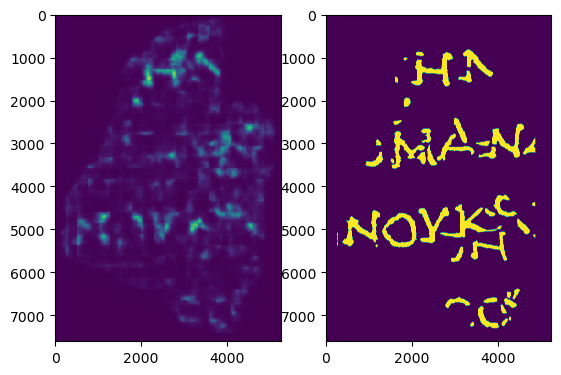

/working/output/exp037/imgs/fold1_average_slice555_valid_pred_img.png
(4943, 9506)
(4943, 9506)


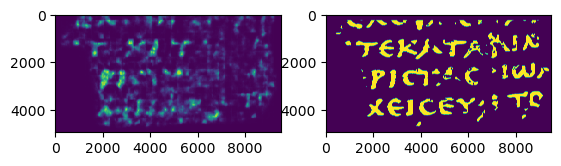

/working/output/exp037/imgs/fold2_average_slice555_valid_pred_img.png
(4943, 9506)
(4943, 9506)


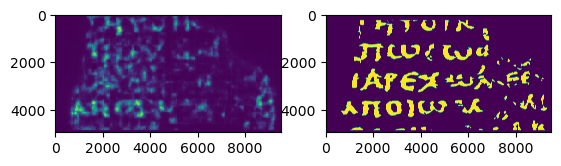

/working/output/exp037/imgs/fold3_average_slice555_valid_pred_img.png
(4943, 9506)
(4943, 9506)


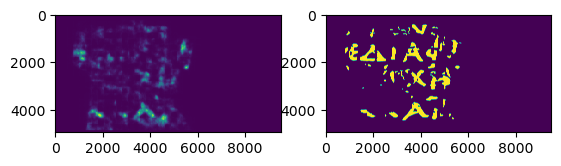

/working/output/exp037/imgs/fold4_average_slice555_valid_pred_img.png


AttributeError: 'NoneType' object has no attribute 'shape'

In [29]:
%%time
pred_flatten_list = []
mask_flatten_list = []
for fold in [0,1,2,3,4]:
    pred_path = os.path.join(CFG["OUTPUT_DIR"], "imgs", f"fold{fold}_average_slice555_valid_pred_img.png")
    mask_path = os.path.join(CFG["OUTPUT_DIR"], "imgs", f"fold{fold}_average_slice555_valid_targets_img.png")
    print(pred_path)
    pred_img = cv2.imread(pred_path, cv2.IMREAD_GRAYSCALE)
    mask_img = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    print(pred_img.shape)
    print(mask_img.shape)
    plt.figure()
    plt.subplot(1, 2, 1)
    plt.imshow(pred_img)
    plt.subplot(1, 2, 2)
    plt.imshow(mask_img)
    plt.show()
    pred_flatten_list.extend(pred_img.flatten())
    mask_flatten_list.extend(mask_img.flatten())

In [ ]:
mask_flatten_list = np.array(mask_flatten_list)/255.
mask = np.array(mask_flatten_list).astype(int)
pred = np.array(pred_flatten_list)/255.

plt.figure()
plt.subplot(1, 2, 1)
plt.hist(pred, bins=100)
plt.subplot(1, 2, 2)
plt.hist(mask)
plt.show()

for th in np.array(range(10, 100+1, 5)) / 100:
    dice = fbeta_numpy(mask, (pred >= th).astype(int), beta=0.5)
    print(f"th={th:.2f}, dice={dice:.4f}")

In [ ]:
auc = roc_auc_score(mask, pred)
print(auc)